## Import and data structuring

In [1]:
import os
import sqlite3
import pandas as pd

## Note: The code currently assumes that the database file is called "AntennaPodBackup.db" and is one directory above the cloned github folder.
con = sqlite3.connect(os.path.join((os.path.dirname(os.getcwd())),"AntennaPodBackup-2022-01-23.db"))

In [2]:
# Read tables
FeedMedia = pd.read_sql_query("SELECT * from FeedMedia", con)
FeedItems = pd.read_sql_query("SELECT * from FeedItems", con)
Feeds = pd.read_sql_query("SELECT * from Feeds", con)

In [3]:
# convert timestamp in ms to datetime objects (why are they in milliseconds?!)
FeedMedia.last_played_time = pd.to_datetime(FeedMedia.last_played_time, unit='ms')
FeedMedia.playback_completion_date = pd.to_datetime(FeedMedia.playback_completion_date, unit='ms')
FeedItems.pubDate = pd.to_datetime(FeedItems.pubDate, unit='ms')

In [4]:
# for future analysis it might be useful to have the years, months and days ready
# FeedMedia['lpt_year']= FeedMedia['last_played_time'].dt.year
# FeedMedia['lpt_month']= FeedMedia['last_played_time'].dt.month
# FeedMedia['lpt_day']= FeedMedia['last_played_time'].dt.day
# FeedMedia['lpt_weekday']= FeedMedia['last_played_time'].dt.dayofweek
# FeedMedia['duration']= FeedMedia['duration']/1000/60
FeedMedia['percentage_played']= FeedMedia['position']/FeedMedia['duration']
# FeedMedia["duration"] = pd.to_timedelta(FeedMedia["duration"],unit="ms")
# FeedMedia['pcd_year']= FeedMedia['playback_completion_date'].dt.year
# FeedMedia['pcd_month']= FeedMedia['playback_completion_date'].dt.month
# FeedMedia['pcd_day']= FeedMedia['playback_completion_date'].dt.day

df = pd.merge(FeedMedia, FeedItems, left_on='feeditem', right_on='id', suffixes=('_media', '_item'))
df = pd.merge(df, Feeds, left_on='feed', right_on='id', suffixes=('', '_feed'))

df.percentage_played.fillna(0,inplace=True)

df["pub_year"] = df["pubDate"].dt.year

## Dash part

In [5]:
from jupyter_dash import JupyterDash
from dash import html
from dash import dcc
from dash.dependencies import Input, Output
import plotly.express as px

In [54]:
app = JupyterDash(__name__)

app.layout = html.Div(children = [
    dcc.Dropdown(
        id="podcasts", 
        placeholder="Select some podcasts", 
        clearable=False, 
        options=[{"label": y, "value": y} for y in df["title_feed"].unique()],
        multi=True
    ),
    dcc.RangeSlider(
        id='year_slider',
        min=1990,
        max=2030,
        step=1,
        value=[2018, 2022],
        tooltip={"placement": "bottom", "always_visible": True}
    ),
    dcc.Graph(id="release", figure={}),
              
    dcc.Graph(id="bar-plot", figure={}),
    ])
    
    
@app.callback(Output("release", "figure"),
              Input("year_slider", "value"),
              Input("podcasts", "value"))
def year_range(year_slider,podcasts):
    # Scatter plot with weekday and duration in minutes
    df1 = df[df.playback_completion_date.dt.year.isin(range(year_slider[0],year_slider[1]))]
    if podcasts:
        df2 = df1[df1.title_feed.isin(podcasts)]
        fig = px.scatter(df2[df2["percentage_played"]>0], 
                 template="plotly_dark",
                 color_discrete_sequence=px.colors.qualitative.Bold,
                 y="duration", 
                 x="pubDate", 
                 color="title_feed", 
                 size = "percentage_played", 
                 height=500, 
                 range_x=year_slider,
                 )
    
    else:
        fig = px.scatter(df1[df1["percentage_played"]>0], 
                 template="plotly_dark",
                 color_discrete_sequence=px.colors.qualitative.Bold,
                 y="duration", 
                 x="pubDate", 
                 color="title_feed", 
                 size = "percentage_played", 
                 height=500, 
                 range_x=year_slider,
                 )
        
    return fig.update_layout(font_family="Rockwell",
                             showlegend=False,
                             legend=(dict(orientation="h", 
                                          title="", 
                                         )))

@app.callback(Output("bar-plot", "figure"),
              Input("year_slider", "value"),
              Input("podcasts", "value"))
def party(year_slider,podcasts):
    df1 = df[df.playback_completion_date.dt.year.isin(range(year_slider[0],year_slider[1]))]
    if podcasts:
        df2 = df1[df1.title_feed.isin(podcasts)]
        fig2 = px.bar(df2[df2["played_duration"]>0],
           template="plotly_dark",
           x=df2['playback_completion_date'].dt.dayofweek, 
           y=df2["played_duration"]/1000/60,
           color=df2['playback_completion_date'].dt.year.astype(str),
           color_discrete_sequence=px.colors.qualitative.Bold)
    
    else:
        fig2 = px.bar(df1[df1["played_duration"]>0],
           template="plotly_dark",
           x=df1['playback_completion_date'].dt.dayofweek, 
           y=df1["played_duration"]/1000/60,
           color=df1['playback_completion_date'].dt.year.astype(str),
           color_discrete_sequence=px.colors.qualitative.Bold)
        
    return fig2.update_layout(font_family="Rockwell",
                             showlegend=False,
                             legend=(dict(orientation="h", 
                                          title="", 
                                         )))
    
app.run_server(mode="jupyterlab")

In [7]:
list(df.columns.values)

['id_media',
 'duration',
 'file_url',
 'download_url',
 'downloaded',
 'position',
 'filesize',
 'mime_type',
 'playback_completion_date',
 'feeditem',
 'played_duration',
 'has_embedded_picture',
 'last_played_time',
 'lpt_year',
 'lpt_month',
 'lpt_day',
 'lpt_weekday',
 'duration_minutes',
 'percentage_played',
 'pcd_year',
 'pcd_month',
 'pcd_day',
 'id_item',
 'title',
 'content_encoded',
 'pubDate',
 'read',
 'link',
 'description',
 'payment_link',
 'media',
 'feed',
 'has_simple_chapters',
 'item_identifier',
 'image_url',
 'auto_download',
 'id',
 'title_feed',
 'custom_title',
 'file_url_feed',
 'download_url_feed',
 'downloaded_feed',
 'link_feed',
 'description_feed',
 'payment_link_feed',
 'last_update',
 'language',
 'author',
 'image_url_feed',
 'type',
 'feed_identifier',
 'auto_download_feed',
 'username',
 'password',
 'include_filter',
 'exclude_filter',
 'keep_updated',
 'is_paged',
 'next_page_link',
 'hide',
 'sort_order',
 'last_update_failed',
 'auto_delete_act

In [ ]:
# Scatter plot with weekday and duration in minutes
fig = px.scatter(df[df["lpt_year"] != 1970],
                 color_discrete_sequence=px.colors.qualitative.Vivid,
                 template="plotly_dark",
                 y="duration",
                 x="lpt_weekday", 
                 color="lpt_month", 
                 size="percentage_played", 
                 hover_name="title_feed",
                 hover_data={"title" : True,
                             "lpt_weekday" : False,
                             "lpt_month" : False,
                             "percentage_played" : False,
                             "duration" : True,},
                 title="Played Episodes",
                 height=500)
fig.update_layout(font_family="Rockwell",
                  legend=(dict(orientation="h", title="")))

In [ ]:
# Scatter plot with weekday and duration in minutes
fig = px.scatter(df, 
                 y="duration_minutes", 
                 x="pub_year", 
                 color="title_feed", 
                 size = "percentage_played", 
                 height=500, 
                 range_x=[2000,2025])
fig.update_layout(font_family="Rockwell",
                  legend=(dict(orientation="v", title="")))

In [16]:
df

,id_media,duration,file_url,download_url,downloaded,position,filesize,mime_type,playback_completion_date,feeditem,...,sort_order,last_update_failed,auto_delete_action,feed_playback_speed,feed_volume_adaption,feed_skip_intro,feed_skip_ending,episode_notification,tags,pub_year
0,1,0 days 00:08:59.140000,None,http://open.live.bbc.co.uk/mediaselector/6/red...,0,0,8608000,audio/mpeg,1970-01-01 00:00:00.000,1,...,None,0,0,-1.0,0,0,0,0,#root,2020
1,2,0 days 00:23:18,None,http://open.live.bbc.co.uk/mediaselector/6/red...,0,0,22368000,audio/mpeg,1970-01-01 00:00:00.000,2,...,None,0,0,-1.0,0,0,0,0,#root,2020
2,3,0 days 00:10:10,None,http://open.live.bbc.co.uk/mediaselector/6/red...,0,0,9760000,audio/mpeg,1970-01-01 00:00:00.000,3,...,None,0,0,-1.0,0,0,0,0,#root,2020
3,4,0 days 00:28:24,None,http://open.live.bbc.co.uk/mediaselector/6/red...,0,0,27264000,audio/mpeg,1970-01-01 00:00:00.000,4,...,None,0,0,-1.0,0,0,0,0,#root,2020
4,5,0 days 00:08:58,None,http://open.live.bbc.co.uk/mediaselector/6/red...,0,0,8608000,audio/mpeg,1970-01-01 00:00:00.000,5,...,None,0,0,-1.0,0,0,0,0,#root,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35944,39140,0 days 00:28:39,None,https://wdrmedien-a.akamaihd.net/medp/podcast/...,0,0,28316544,audio/mpeg,1970-01-01 00:00:00.000,39157,...,None,0,0,-1.0,0,0,0,0,#root,2021
35945,38858,0 days 00:24:02.208000,None,http://open.live.bbc.co.uk/mediaselector/6/red...,0,0,11024000,audio/mpeg,2021-08-23 16:49:44.246,38875,...,None,0,0,-1.0,0,0,0,0,#root,2021
35946,38859,0 days 00:23:28.940000,None,http://open.live.bbc.co.uk/mediaselector/6/red...,0,0,11264000,audio/mpeg,2021-08-23 16:25:40.341,38876,...,None,0,0,-1.0,0,0,0,0,#root,2021
35947,38860,0 days 00:03:10,None,http://open.live.bbc.co.uk/mediaselector/6/red...,0,0,1520000,audio/mpeg,1970-01-01 00:00:00.000,38877,...,None,0,0,-1.0,0,0,0,0,#root,2021


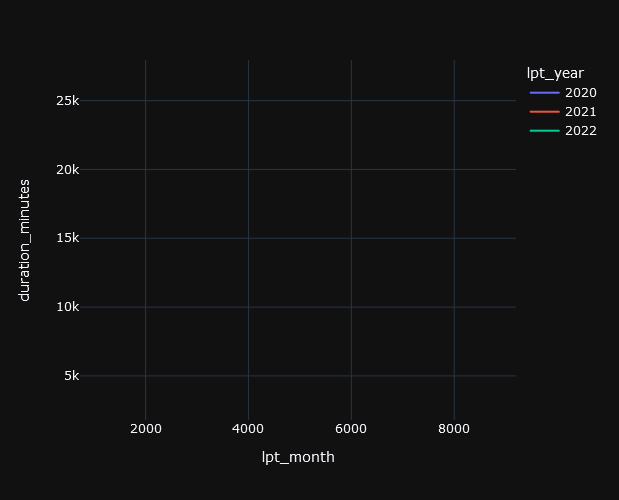

In [55]:
df3 = df[df["lpt_year"]>1970].groupby(by=["lpt_year",
                                          #"lpt_month"
                                         ]).sum()
px.line(df3,
           template="plotly_dark",
           y="duration_minutes",
           x="lpt_month",#df3.index,#.get_level_values(0), 
           height=500,
           color=df3.index)

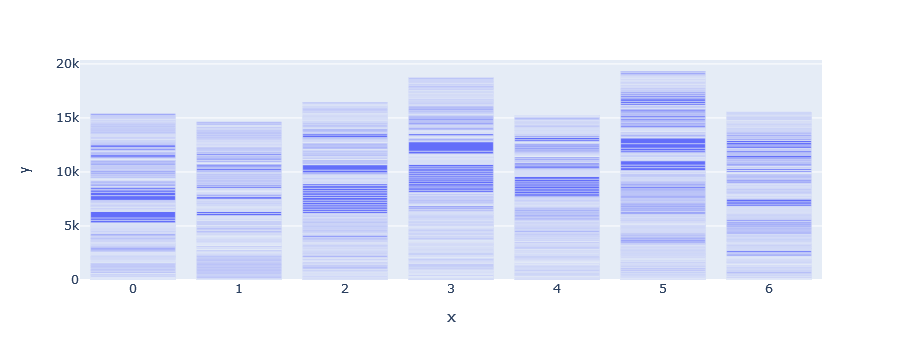

In [40]:
px.bar(df[df["played_duration"]>0],#.groupby(['playback_completion_date'].dt.dayofweek),
       x=df['playback_completion_date'].dt.dayofweek, 
       y=df["played_duration"]/1000/60
      )

In [37]:
df["played_duration"]

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
41886          NaN
41887          NaN
41888          NaN
41889          NaN
41890    3549840.0
Name: played_duration, Length: 41891, dtype: float64